In [71]:
import networkx as nx
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableSequence

import re 
import numpy as np
from networkx.algorithms.approximation import traveling_salesman_problem
from dotenv import load_dotenv

import googlemaps
import os
from geopy.geocoders import Nominatim
import time
import geopandas as gpd

import matplotlib.pyplot as plt
import contextily as ctx

load_dotenv("hidden.env")

True

In [15]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
maps_API_KEY = os.getenv('maps_API_KEY')
gmaps = googlemaps.Client(key=maps_API_KEY) 
geolocator = Nominatim(user_agent="tsp")

def seconds_to_hours(seconds): 
    if type(seconds) == str:
        s = int(seconds.split())
    else: 
        s = seconds
    return s/3600

In [137]:
## First we create a prompt to ask for either landmarks, towns, cities, within the given place for the given number 

def get_location(): 

    location = input("Enter the location, this can be a country, city, or region: ")
    number = int(input("Enter the number of locations to visit: "))
    if number > 10: 
        print("Number of nodes is too large, currently limited to using 10 locations. Please Enter a smaller number.")
        number = int(input("Enter the number of locations to visit: "))
        
    node_type = input("Enter type of place to include e.g. countries, towns, landmarks, etc:")
    priority = input("Enter the priority of the path, one of [time, distance, cost, total]:")

    prompt1 = PromptTemplate(
        input_variables=["number", "location", "node_type"],
        template="List {number} {node_type} to visit in {location}. One per line, itemized."
    )

    chat = ChatOpenAI(model="gpt-4", temperature=1.0)
    chain = prompt1 | chat
    response = chain.invoke({"number": number,"location": location, "node_type": node_type})
    original_nodes = re.findall(r"\d+\.\s*(.+)", response.content)
    nodes = [node + ", " + location for node in original_nodes]

    if priority == 'time': 
        p = 0
    elif priority == 'distance':
        p = 1
    elif priority == 'cost':
        p = 2
    else: 
        p = 3
    
    return original_nodes, nodes, p

def fuel_price(location): 
    """ A function I intended to implement with an API or scraping to get the fuel price (in order to estimate cost). 
        For now, I will just use the LLM (which is very naive).
    """

    gbp = 1.03
    prompt = PromptTemplate(
        input_variables=["location"],
        template="Return 1.03 GBP in the local currency of {location}. Only the number."
    )
    chain = prompt | ChatOpenAI(model="gpt-4", temperature=0.0)
    response = chain.invoke({"location": location})
    try:
        price = float(response.content)
    except:
        price = 1.03 # in the event of failure just use gbp as a default 
    return price

def estimate_driving_cost(distance, fuel_price, fuel_efficiency = 6.5): 

    """ A function to estimate the cost of driving a given distance. The fuel efficiency is in litres per 100 km. 
        distance is in km. fuel_price is in local currency per litre. 
    """

    litres = distance * fuel_efficiency / 100 
    cost = litres * fuel_price
    return cost

In [146]:
def get_distances(nodes, number, p): 
    
    # scale factors for time, distance, and cost (based on priority
    sf = [[3, 1, 1], [1, 3, 1], [1, 1, 3], [1, 1, 1]][p] 
    
    positions = {}
    backup_prompt = PromptTemplate(
        input_variables=["place"],
        template = "Return the longitude and latitude of {place}. "
                "In the format (latitude, longitude). No other text.")

    for i in range(number): 
        node = geolocator.geocode(nodes[i])
        if not node: 
            chat = ChatOpenAI(model="gpt-4", temperature=0.0)
            chain = backup_prompt | chat
            response = chain.invoke({"place": nodes[i]}).content
            match = re.search(r"\(?\s*(-?\d+\.\d+)\s*,\s*(-?\d+\.\d+)\s*\)?", response)
            if match:
                lat = float(match.group(1))
                lon = float(match.group(2))
            positions[i] = (lat, lon)
        else:
            positions[i] = (node.latitude, node.longitude)
            time.sleep(1) # to prevent overloading the geolocator API

    coords = list(positions.values())

    ## Get the distance matrices 
    # 1 Walking 
    walking_distances = gmaps.distance_matrix(coords, coords, mode = 'walking')
    # 2 Driving 
    driving_distances = gmaps.distance_matrix(coords, coords, mode = 'driving')
    # 3 Bicycling
    bicycling_distances = gmaps.distance_matrix(coords, coords, mode = 'bicycling')
    # 4 Transit
    transit_distances = gmaps.distance_matrix(coords, coords, mode = 'transit')

    ## Now need to add in a flight option (this will be an estimate since )
    transport_prompt = PromptTemplate(
        input_variables=["priority_superlative", "place1", "place2"],
        template= "Return the time (in hours), the method of transport (e.g. car, plane, foot, boat, etc), "
        "the distance for that method (km), and the price (in the local currency) of using that method. "
        "This should be the {priority_superlative} way of travelling from {place1} to {place2}. "
        "Return it in this format: (method, time, distance, price). No other text.")

    superlatives = ["fastest", "shortest (distance)", "cheapest", "best (combination of time, distance, and cost)"]
    
    # At this point, we have the distance, time, but not cost for each pair of nodes 
    # I think we go off of the assumption that walking and cycling are free, and driving and transit have a cost 
    d = {} # d[i][j][mode] = [time, distance, cost]
    chat = ChatOpenAI(model="gpt-4", temperature=0.0)
    chain = transport_prompt | chat
    if number <= 10:
        lists = [walking_distances, driving_distances, bicycling_distances, transit_distances]
        
    mode_names = ["foot", "car", "bike", "transit", "llm"]
    for origin in range(number): 
        d[origin] = {}
        for dest in range(origin + 1, number): 
            d[origin][dest] = {}

            response = chain.invoke({"priority_superlative": superlatives[p], "place1": nodes[origin], "place2": nodes[dest]}).content
            match = re.search(
                r"\(\s*(.+?)\s*,"             # Method
                r"\s*([\d.]+)\s*\w*\s*,"      # Time (float + optional 'hours' or 'h')
                r"\s*([\d.]+)\s*\w*\s*,"      # Distance (float + optional 'km' etc.)
                r"\s*(?:[\$£€]|)?([\d.]+)(?:\s*\w+)?\s*\)",  # Price: optional symbol or currency word
                response)

            if match:
                method = match.group(1)
                t = float(match.group(2))
                distance = float(match.group(3))
                cost = float(match.group(4))
                d[origin][dest]['llm'] = [t, distance, cost, method]
            
            else: 
                d[origin][dest]['llm'] = [np.inf, np.inf, np.inf, '']

            for i in range(4): 

                element = lists[i]['rows'][origin]['elements'][dest]
                dist = element['distance']['value']/1000
                t = seconds_to_hours(element['duration']['value'])
                if i in [0, 2]:
                    cost = 0
                elif i == 1: 
                    cost = estimate_driving_cost(dist, fuel_price(nodes[origin]))
                else: 
                    fare = element.get('fare', None)
                    if fare: 
                        cost = fare['value']
                    else:
                        cost = dist * 0.5 # just a placeholder for now 
                    
                d[origin][dest][mode_names[i]] = [t, dist, cost]
    
        
            max_dist = max([d[origin][dest][mode][1] for mode in mode_names if d[origin][dest][mode][1] < np.inf])
            max_time = max([d[origin][dest][mode][0] for mode in mode_names if d[origin][dest][mode][0] < np.inf])
            max_cost = max([d[origin][dest][mode][2] for mode in mode_names if d[origin][dest][mode][2] < np.inf])

            d[origin][dest]['distances'] = [d[origin][dest][mode][1]/max_dist for mode in mode_names]
            d[origin][dest]['times'] = [d[origin][dest][mode][0]/max_time for mode in mode_names]
            d[origin][dest]['costs'] = [d[origin][dest][mode][2]/max_cost for mode in mode_names]

            # penalties for each of the methods 
            penalties = []
            for i in range(4):
                penalties.append(sf[1]*d[origin][dest]['distances'][i] + sf[0]*d[origin][dest]['times'][i] + sf[2]*d[origin][dest]['costs'][i])
            
            best = np.argmin(penalties)
            # penalty, mode, time, distance, cost
            d[origin][dest]['best'] = [penalties[best], mode_names[best], d[origin][dest][mode_names[best]][0], d[origin][dest][mode_names[best]][1], d[origin][dest][mode_names[best]][2]]

    return d, positions

In [147]:
original_nodes, nodes, p = get_location()
d, positions = get_distances(nodes, len(nodes), p)

In [148]:
def build_graph(d, number, nodes): 

    G = nx.complete_graph(number)
    labels = {i: nodes[i] for i in range(number)}

    for i in range(number): 
        for j in range(i + 1, number): 
            G[i][j]["weight"] = d[i][j]['best'][0]
    
    return G, labels

In [155]:
def solve_graph(G, p, labels, original_nodes, cycle = False):

    tsp_path = traveling_salesman_problem(G, weight='weight', cycle=cycle)
    #total_cost = sum(G[tsp_path[i]][tsp_path[i + 1]]['weight'] for i in range(len(tsp_path) - 1))

    # total_time = sum(d[tsp_path[i]][tsp_path[i + 1]]['best'][2] for i in range(len(tsp_path) - 1))
    # total_distance = sum(d[tsp_path[i]][tsp_path[i + 1]]['best'][3] for i in range(len(tsp_path) - 1))
    # total_cost = sum(d[tsp_path[i]][tsp_path[i + 1]]['best'][4] for i in range(len(tsp_path) - 1))
    # priority_names = ['time', 'distance', 'cost', 'total']
    # priority_units = ['hours', 'km', 'local currency']

    # print("TSP Approximate Path:", [labels[node] for node in tsp_path])
    # print(f"Total time: {total_time:.2f} hours.")
    # print(f"Total distance: {total_distance:.2f} km.")
    # print(f"Total cost: {total_cost:.2f} local currency.")
    # print(f"Priority: {priority_names[p]}")

    p_str = ['t_priority', 'd_priority', 'c_priority', 'total_priority'][p]

    # Modes 
    for journey in range(len(tsp_path) - 1): 
        if tsp_path[journey + 1] < tsp_path[journey]: 
            print(f"Journey from {original_nodes[tsp_path[journey]]} to {original_nodes[tsp_path[journey + 1]]}: {d[tsp_path[journey + 1]][tsp_path[journey]]['best'][0]}")
        else: 
            print(f"Journey from {original_nodes[tsp_path[journey + 1]]} to {original_nodes[tsp_path[journey + 1]]}: {d[tsp_path[journey]][tsp_path[journey + 1]]['best'][0]}")
        
    return tsp_path#, total_cost


def plot_graph(G, positions, labels, map = False):


    fig, ax = plt.subplots(figsize=(10, 10))

    if map: 

        node_coords = [(lon, lat) for _, (lat, lon) in positions.items()]
        gdf_nodes = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*zip(*node_coords)), crs='EPSG:4326')
        gdf_nodes = gdf_nodes.to_crs(epsg=3857)  # Web Mercator for tile maps

        projected_positions = {n: (gdf_nodes.geometry[i].x, gdf_nodes.geometry[i].y) for i, n in enumerate(G.nodes())}

        # Plot
        nx.draw(G, pos=projected_positions, ax=ax, node_color='skyblue', node_size=800, with_labels=False,edge_color='grey')
        nx.draw_networkx_labels(G, pos=projected_positions, labels = labels, font_size=12, font_weight='bold')
        # Add basemap tiles
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    else: 
        node_coords = [(lon, lat) for _, (lat, lon) in positions.items()]
        labs = {i: f"{i}: {labels[i]}" for i in range(len(labels))}
        nx.draw(G, pos=node_coords, with_labels=True, node_color='lightblue', node_size=1000)
        nx.draw_networkx_labels(G, pos=positions, labels=labs, font_size=12)
        edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels)

    plt.title("Weighted Graph (TSP Nodes)")
    plt.show()
    return 


In [156]:
def plot_path(G, tsp_path, positions, nodes, total_cost, p, map=True):

    priority_names = ['time', 'distance', 'cost']
    priority_units = ['hours', 'km', 'local currency']

    fig, ax = plt.subplots(figsize=(10, 10))

    if len(tsp_path) == len(G.nodes()):
        ordered_labels = {node: f"{i}" for i, node in enumerate(tsp_path)}
    else: 
        ordered_labels = {node: f"{i}" for i, node in enumerate(tsp_path[:-1])}

    tsp_edges = list(zip(tsp_path[:-1], tsp_path[1:]))
    start_node = tsp_path[0]
    node_colors = ['red' if node == start_node else 'skyblue' for node in G.nodes()]

    if map:
        # Create GeoDataFrame in lat/lon then project to Web Mercator
        node_coords = [(lon, lat) for _, (lat, lon) in positions.items()]
        gdf_nodes = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*zip(*node_coords)), crs='EPSG:4326')
        gdf_nodes = gdf_nodes.to_crs(epsg=3857)

        # Create projected position mapping using original node keys
        projected_positions = {
            node: (point.x, point.y)
            for node, point in zip(positions.keys(), gdf_nodes.geometry)
        }

        # Draw all nodes and edges
        nx.draw(G, pos=projected_positions, ax=ax, node_color=node_colors, node_size=800,
                with_labels=False, edge_color='lightgray', width=1)

        # Draw labels in order of tsp path
        nx.draw_networkx_labels(G, pos=projected_positions, labels=ordered_labels, font_size=14, font_weight='bold')

        # Highlight the TSP edges
        nx.draw_networkx_edges(G, pos=projected_positions, edgelist=tsp_edges, edge_color='red', width=3, ax=ax)

        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    else:
        # Same as above but without map projection
        node_coords = [(lon, lat) for _, (lat, lon) in positions.items()]
        nx.draw(G, node_coords, ax=ax, with_labels=False, node_color=node_colors, node_size=800, edge_color='gray')
        nx.draw_networkx_labels(G, node_coords, labels=ordered_labels, font_size=14, font_weight='bold')
        nx.draw_networkx_edges(G, pos=node_coords, edgelist=tsp_edges, edge_color='red', width=3)

    # Add route legend (index -> name)
    label_mapping_legend = [
        f"{label}: {nodes[node]}" for node, label in ordered_labels.items()
    ]
    legend_text = "\n".join(label_mapping_legend)
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(1.02, 0.5, legend_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='center', bbox=props)

    plt.title(f"TSP Path Total {priority_names[p]}: {total_cost:.2f} {priority_units[p]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return


In [157]:
def plot_graph_and_path(G, tsp_path, positions, nodes, total_cost, p, map=True):

    priority_names = ['time', 'distance', 'cost']
    priority_units = ['hours', 'km', 'local currency']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # --- Shared preparation ---
    node_coords = [(lon, lat) for _, (lat, lon) in positions.items()]
    if map:
        gdf_nodes = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*zip(*node_coords)), crs='EPSG:4326')
        gdf_nodes = gdf_nodes.to_crs(epsg=3857)
        projected_positions = {
            node: (point.x, point.y)
            for node, point in zip(positions.keys(), gdf_nodes.geometry)
        }
        pos = projected_positions
    else:
        pos = {n: (lon, lat) for n, (lat, lon) in positions.items()}

    # --- Graph View (Left Plot) ---
    labels = {i: nodes[i] for i in G.nodes()}
    node_colors = ['skyblue' for _ in G.nodes()]

    nx.draw(G, pos=pos, ax=ax1, node_color=node_colors, node_size=800, edge_color='grey', with_labels=False)
    nx.draw_networkx_labels(G, pos=pos, labels=labels, ax=ax1, font_size=12)
    
    if not map:
        edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax1)

    ax1.set_title("Full Graph")
    ax1.axis("off")
    if map:
        ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)

    # --- TSP Path View (Right Plot) ---
    if len(tsp_path) == len(G.nodes()):
        ordered_labels = {node: f"{i}" for i, node in enumerate(tsp_path)}
    else:
        ordered_labels = {node: f"{i}" for i, node in enumerate(tsp_path[:-1])}

    tsp_edges = list(zip(tsp_path[:-1], tsp_path[1:]))
    start_node = tsp_path[0]
    node_colors = ['red' if node == start_node else 'skyblue' for node in G.nodes()]

    nx.draw(G, pos=pos, ax=ax2, node_color=node_colors, node_size=800, edge_color='lightgray', with_labels=False)
    nx.draw_networkx_labels(G, pos=pos, labels=ordered_labels, ax=ax2, font_size=14, font_weight='bold')
    nx.draw_networkx_edges(G, pos=pos, edgelist=tsp_edges, edge_color='red', width=3, ax=ax2)

    if map:
        ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)

    # Legend (right)
    label_mapping_legend = [f"{label}: {nodes[node]}" for node, label in ordered_labels.items()]
    legend_text = "\n".join(label_mapping_legend)
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax2.text(1.02, 0.5, legend_text, transform=ax2.transAxes, fontsize=12,
             verticalalignment='center', bbox=props)

    ax2.set_title(f"TSP Path Total {priority_names[p]}: {total_cost:.2f} {priority_units[p]}")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()


Journey from The London Eye to The London Eye: 1.055425406160233
Journey from The London Eye to The British Museum: 0.9967587337621391


IndexError: list index out of range

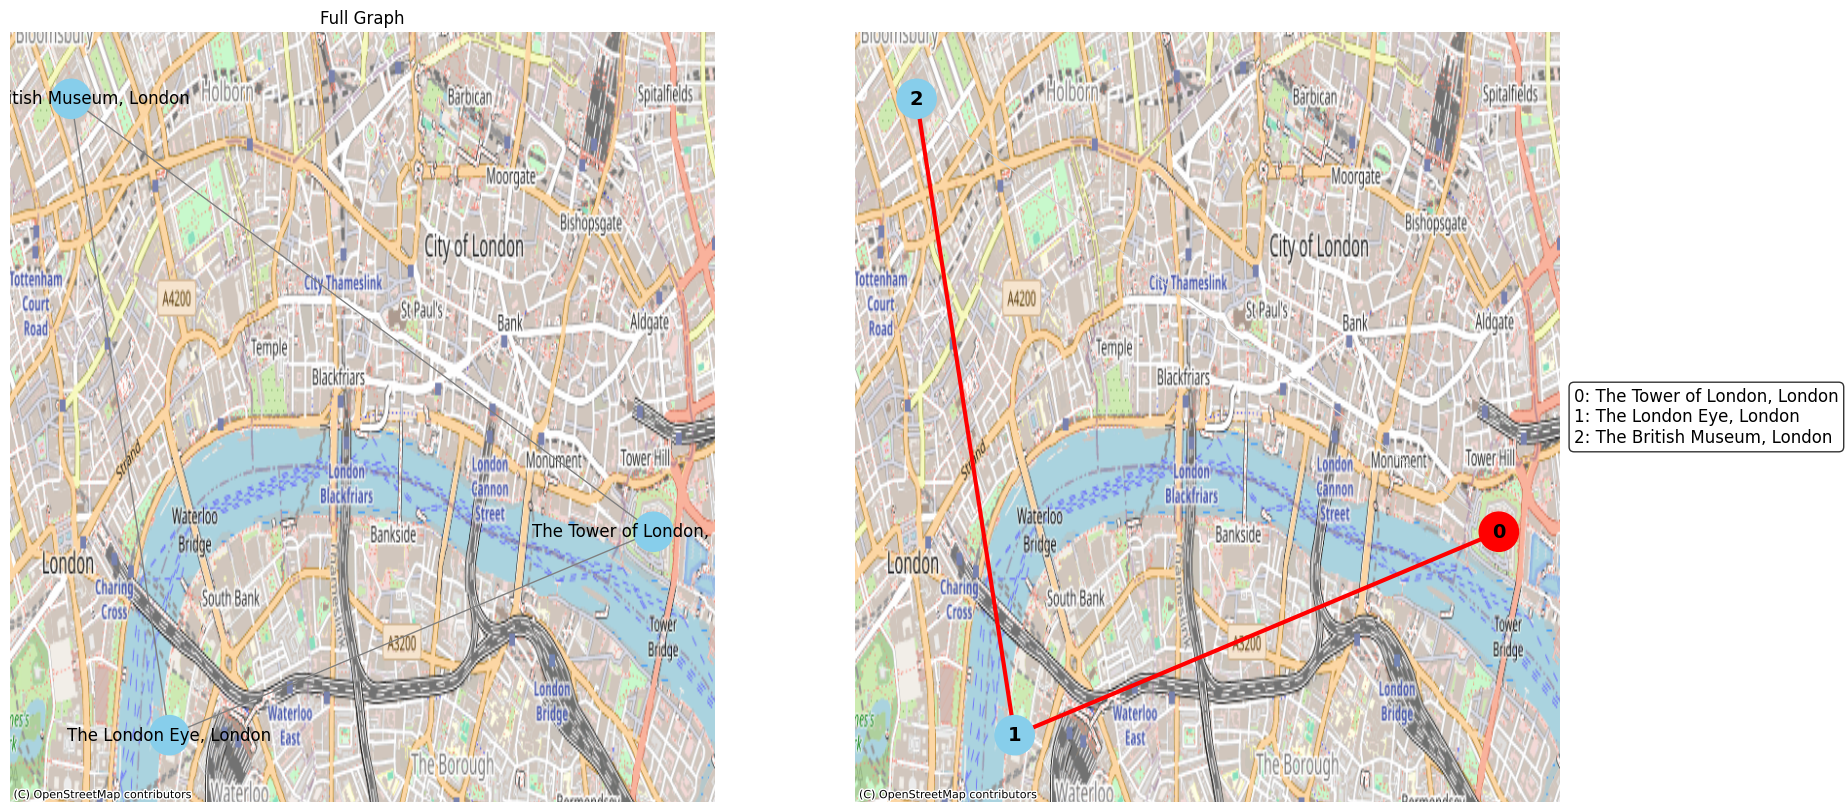

In [158]:
original_nodes, nodes, p = get_location()
d, positions = get_distances(nodes, len(nodes), p)
G, labels = build_graph(d, len(nodes), nodes)
tsp_path = solve_graph(G, p, labels, original_nodes)
plot_graph_and_path(G, tsp_path, positions, nodes, p, map=True)